<a href="https://colab.research.google.com/github/mtiezzi/foveated_neural_computation/blob/main/foveated_convolutional_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import torch
from torchvision import transforms
from fov_conv2d_cont import FovConv2dCont, LinearMiddleBiasOne
from fov_conv2d_reg import FovConv2dReg
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import requests
import math
import numpy as np

Load an image from the web

In [2]:
# living room picture  (put here the image url)
image_url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2016/03/10/18/mona-lisa.jpg?width=1200&height=900&fit=crop'

Some standard hyperparameters

In [3]:
# other standard customizable options
h = 224
w = 224
in_channels = 1
out_channels = 1
kernel_size = 7
device = "cpu"

In [4]:
# get an RGB image from the web
image = Image.open(requests.get(image_url, stream=True).raw).resize((w, h), Image.ANTIALIAS).convert('RGB')
image = transforms.ToTensor()(image).unsqueeze_(0).mean(1, keepdim=True).to(device)

C:\Users\appel\AppData\Local\Temp\ipykernel_26072\2485830067.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = Image.open(requests.get(image_url, stream=True).raw).resize((w, h), Image.ANTIALIAS).convert('RGB')


In [6]:
# set the FOA coordinates to the center of the image
foa_xy = torch.tensor([[h // 2, w // 2]], dtype=torch.long)

Here is how a common conv2d would be defined:

` netc = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2, padding_mode='zeros')`

We propose several variants of FCLs:

### Piecewise-defined Foveated Convolutional Layer

Foveated Convolutional Layer with a region-based dependency from the FOA coordinates, uniform spatial coverage, with a strong emphasis on speed/reduced-computations and control.

This type of layer allows the user to specify a 'reduction factor' that tells how strongly the cost of convolution
should be reduced when moving far away from the FOA. The image is divided into a fixed number of regions/areas
around the FOA, and each of them has its own 'reduction factor'. The region that contains the FOA usually has the
lowest reduction factor.
  
Convolution is made cheaper by reducing the number of kernel components (spatially).
 In order to ensure that the
reduced kernels still cover receptive inputs of similar sizes, the input must be downscaled, or stride must be used, or dilation should be exploited. These are the three methods implemented here.

A nice side effect of this class is that it also allows the user to specify a custom model to be used to process the data in each region. 
Regions are downscaled accordingly to the 'reduction factor' and the custom model processes the downscaled crops.


Let's see how to define a Piecewise-defined Foveated Convolutional Layer (Pw-FCL)

In [189]:
def gaussian_region_factors_odd(step_count, max_radius, sigma):
    """
    Generates odd region sizes and reduction factors based on a Gaussian distribution.
    
    Args:
    - step_count: The number of regions (hard steps) to generate.
    - max_radius: The maximum radius for the regions, which will correspond to the last region size.
    - sigma: The standard deviation of the Gaussian distribution.
    
    Returns:
    - A tuple of two lists: (region_sizes, reduction_factors).
    """
    # Ensure we have at least two steps (one for the center, one for the periphery)
    if step_count < 2:
        raise ValueError("step_count must be at least 2")
        
    # Calculate the radii for the specified number of steps ensuring they are odd and increasing
    radii = np.linspace(1, max_radius, step_count - 1)  # reserve the last step for -1
    radii = np.ceil(radii / 2) * 2 - 1  # make odd values
    radii = np.unique(radii)  # ensure they are increasing
    radii = np.append(radii, -1)  # add -1 for the last region
    
    # Adjust step_count in case rounding reduced the number of unique steps
    adjusted_step_count = len(radii)
    
    # Calculate the corresponding Gaussian values
    gaussian_values = np.exp(-0.5 * ((radii[:-1] - radii[0]) / sigma) ** 2)
    # Normalize the Gaussian values to get reduction factors between 0 and 1
    reduction_factors = gaussian_values / gaussian_values[0]
    reduction_factors = np.append(reduction_factors, reduction_factors[-1] * 0.1)  # Reduced factor for the last region

    return tuple(radii.astype(int)), tuple(reduction_factors)

# Example usage:
step_count = 9  # The number of hard steps to approximate Gaussian distribution
max_radius = 150  # The maximum radius of the region
sigma = 100  # Standard deviation of the Gaussian distribution

region_sizes, reduction_factors = gaussian_region_factors_odd(step_count, max_radius, sigma)
region_sizes, reduction_factors 

((1, 23, 43, 65, 87, 107, 129, 149, -1),
 (1.0,
  0.9760904721403703,
  0.9155777428619776,
  0.8148102621687294,
  0.6908724913190898,
  0.570181812337605,
  0.4407841408053245,
  0.33447270571756405,
  0.03344727057175641))

In [190]:
net = FovConv2dReg(in_channels, out_channels, dilation=1, kernel_size=15, region_type="circle", method="stride",
                   padding_mode='zeros',
                   region_sizes=region_sizes, reduction_factors=reduction_factors, 
                   banks="shared", crop_type="loose")

Class arguments:

`:param region_type:`  defines the shape of the regions,  one value from {"circle", "box"}

`:param method:`  defines the type of implementation for the convolution cost reduction {"downscaling",  "dilation", "stride", "vanilla"}

`:param region_sizes:` a tuple of odd integers defining the size of each region (as many elements as the regions)

`:param  reduction_factors:` tuple of float values in (0,1.0] to define the reduction factor with respect to the cost of the convolution in region 1

`:param banks: `using shared filters (Pw-FCL-S) or independent filters (Pw-FCL-I)

`:param  crop_type:` define the type of region crop {None, "none", "loose", "tight"}

Let's do the standard forward pass!

In [191]:
image = image.to(device)
foa_xy = foa_xy.to(device)
net = net.to(device)

out = net(image, foa_xy)

# some dummy loss computation and backward (just to show that it is working)
loss = torch.sum(out[0])
loss.backward()

In [192]:
def visualize(out):
  out = (out.detach() if type(out) is not tuple else out[0].detach()).to("cpu")
  plt.figure(figsize=(15, 15))
  ix = 1
  for j in range(out.shape[1]):
      plt.subplot(out.shape[0], out.shape[1], ix)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(out[0, j, :, :].view(h, w), cmap='gray')
      plt.gcf().gca().add_patch(Circle((foa_xy[0, 1], foa_xy[0, 0]), 3, color='r'))
      ix += 1
  plt.show()


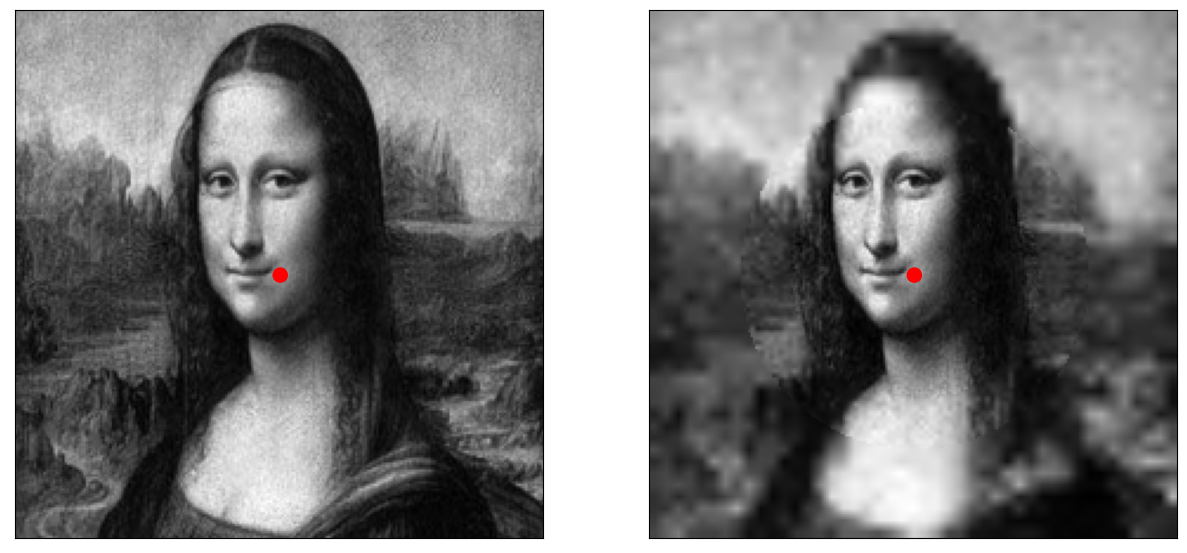

In [193]:
visualize(torch.hstack((image.mean(dim=1).unsqueeze(1), out[0])))

###Other variants of FCLs

Let's try a different variant of FCL.

The `FovConv2dCont` class contains further variants of FCLs, having a continuous dependency from the FOA coordinates.

This type of convolutional layer is based on the idea of exploiting a different kernel in different pixel coordinates, in function on their 'distance' from the FOA.
There are different ways to achieve such an effect. Here we explore three different cases.

   1) A learnable base kernel is modulated by a Gaussian function that depends on the distance from FOA. The actual
       implementation does NOT alter the base kernel. The input data is altered by the Gaussian function (what we refer
       to as 'input modulation') and, afterwards, a classic convolution is applied using the learnable base kernel.
       The Gaussian function is approximated on a squared area ('modulating kernel').

  2) Same as above, but the modulating function is not a Gaussian, but it is computed by a Neural Network that, given
       the difference between the FOA coordinates and the considered (x,y)-pixel, outputs a modulating function. The
       network has some architectural constraints to fulfil (see the code), and it outputs the function on a squared
       area ('modulating kernel').
       
  3) Finally, we considered the case in which a Neural Network that, given the difference between the FOA coordinates
       and the considered (x,y)-pixel, outputs the kernel to be used to compute the convolution (i.e., there is no
       base kernel, we immediately get the kernel to use for each coordinate).








###Gaussian Modulated-FCL:

`:param gaussian_kernel_size:` size of the squared gaussian kernel

`:param  sigma_min:` standard deviation of the gaussian near the foa (see paper)

`:param  sigma_max:` standard deviation of the gaussian far from  the foa (see paper)

`:param sigma_function:` shape of the gaussian {linear, exponential}

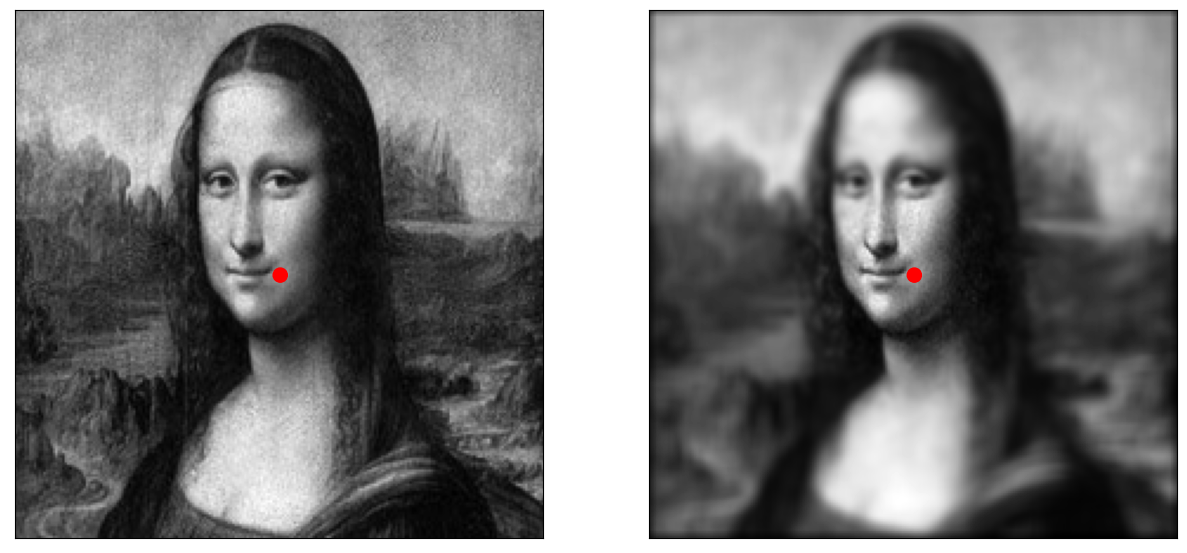

In [15]:
# This is a convolutional layer with all weights = 1, biases = 0
net = FovConv2dCont(in_channels, out_channels=1, kernel_size=11, kernel_type='gaussian_modulated',
                    gaussian_kernel_size=7, sigma_min=0.0001, sigma_max=12, sigma_function='exponential')

out = net(image, foa_xy)

visualize(torch.hstack((image.mean(dim=1).unsqueeze(1), out)))

###Neural Modulated-FCL:

`:param kernel_net:` net to be used as the modulator

In [199]:
net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='net_modulated',
                    kernel_net=torch.nn.Sequential(torch.nn.Linear(2, 10, bias=False), torch.nn.Tanh(),
                                                   LinearMiddleBiasOne(10, 7*7)))

###Neural Generated-FCL:

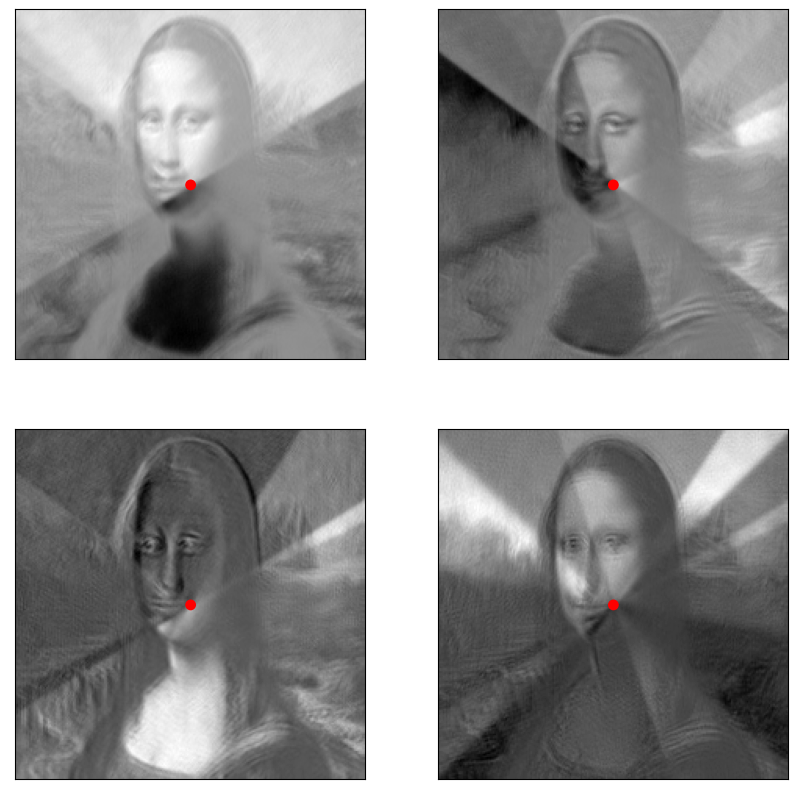

In [201]:

net = FovConv2dCont(in_channels, out_channels, kernel_size, kernel_type='net_generated',
                    padding_mode='replicate',
                    kernel_net=torch.nn.Sequential(torch.nn.Linear(2, 10, bias=True), torch.nn.Tanh(),
                                                   torch.nn.Linear(10, out_channels*in_channels*(kernel_size**2))))  
out = net(image, foa_xy)

visualize(out)

### Injecting/Stacking FCLs into standard nets
Finally, here we show how is it simple to inject FCLs into standard network with other Conv2ds. The only additional argument is the FOA location. 

We build a standard wrapper to handle the stack of layers.
We show three acrchitectures (`'cnn'`: 3 conv2d layers, `'fov_reg_all'`: 3 Pw-FCL layers, `'fov_reg_last'`: 2 conv2d+a last FCL layer ).

The user can select the architecture they want to test it.

In [149]:
class SequentialFeatureExtractor(torch.nn.Module):
    def __init__(self, arch_type):
        super(SequentialFeatureExtractor, self).__init__()

        if arch_type == 'cnn':
            self.layer_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=5, dilation=2, padding=4, bias=True)
            self.layer_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=5, dilation=2, padding=4, bias=True)
            self.layer_3 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=7, dilation=2, padding=6, bias=True)

        elif arch_type == 'fov_reg_all':
            self.layer_1 = FovConv2dReg(in_channels, out_channels, kernel_size=5, dilation=2, region_type="circle",
                                        method="downscaling", region_sizes=(29 + 8 + 8, -1),
                                        reduction_factors=(1.0, 0.25), banks="shared", bias=True)
            self.layer_2 = FovConv2dReg(out_channels, out_channels, kernel_size=5, dilation=2, region_type="circle",
                                        method="downscaling", region_sizes=(29 + 8, -1),
                                        reduction_factors=(1.0, 0.25), banks="shared", bias=True)
            self.layer_3 = FovConv2dReg(out_channels, out_channels, kernel_size=7, dilation=2, region_type="circle",
                                        method="downscaling", region_sizes=(29, -1),
                                        reduction_factors=(1.0, 0.25), banks="shared", bias=True)

        elif arch_type == 'fov_reg_last':
            self.layer_1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=5, dilation=2, padding=4, bias=True)
            self.layer_2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=5, dilation=2, padding=4, bias=True)
            self.layer_3 = FovConv2dReg(out_channels, out_channels, kernel_size=7, dilation=2, region_type="circle",
                                        method="downscaling", region_sizes=(29, -1),
                                        reduction_factors=(1.0, 0.25), banks="shared", bias=True)

    def forward(self, _input_data, _foa_xy):
        if type(self.layer_1) is FovConv2dReg:
            # if FCL, have to give as input also the FOA location
            x = self.layer_1(_input_data, _foa_xy, compute_region_indices=False)
        elif type(self.layer_1) is FovConv2dCont:
            x = self.layer_1(_input_data, _foa_xy)
        else:
            x = self.layer_1(_input_data)

        x = torch.nn.functional.leaky_relu(x)

        if type(self.layer_2) is FovConv2dReg:
            x = self.layer_2(x, _foa_xy, compute_region_indices=False)
        elif type(self.layer_2) is FovConv2dCont:
            x = self.layer_2(x, _foa_xy)
        else:
            x = self.layer_2(x)

        x = torch.nn.functional.leaky_relu(x)

        if type(self.layer_3) is FovConv2dReg:
            x, reg_idx = self.layer_3(x, _foa_xy, compute_region_indices=True)
        elif type(self.layer_3) is FovConv2dCont:
            x = self.layer_3(x, _foa_xy)
            reg_idx = None
        else:
            x = self.layer_3(x)
            reg_idx = None

        x = torch.nn.functional.leaky_relu(x)
        return x, reg_idx

Select the architecture


In [150]:
arch_type = "fov_reg_last"

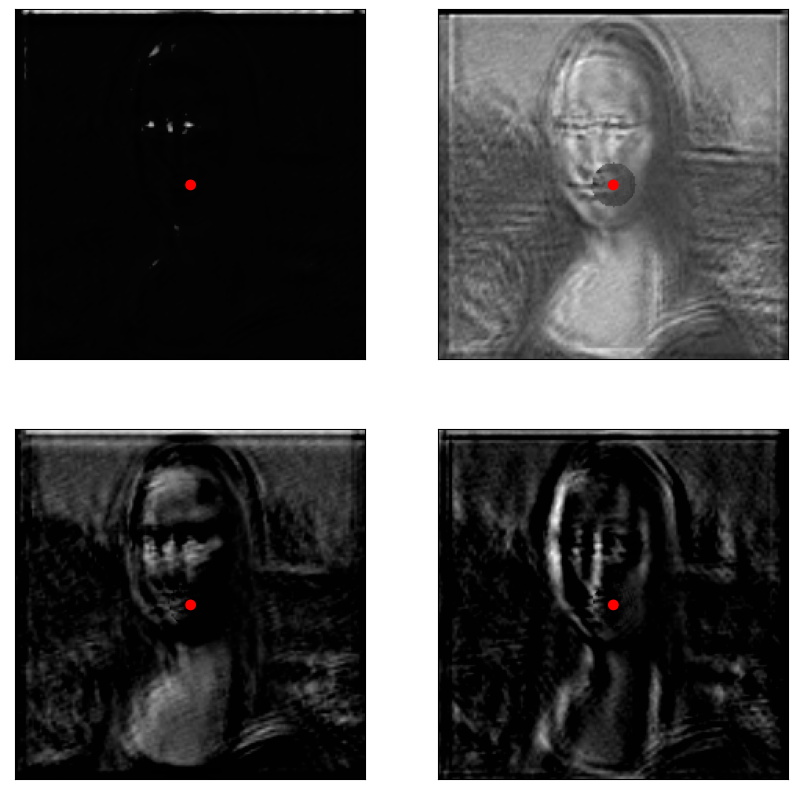

In [151]:
net = SequentialFeatureExtractor(arch_type).to(torch.device(device))
out = net(image, foa_xy)

visualize(out)